# Variational Autoencoder

Autoencoders are neural network architectures used to:
* Encoder data - Create lower-dimension representations of input data.
* Decode data - From these lower-dimension representations, re-create the input data.

Variational autoencoders are a form of autoencoder that learns latent (lower-dimensional) *distribution* of inputs' mean and standard deviation. There is then a **sampling** layer after the latent encoding layer that samples from these mean and standard deviation distributions, 'generating' a new, realistic synthetic observation.

In [838]:
# Commented out for non-Colab user

# # re upload files everytime run

# from google.colab import files

# uploaded = files.upload()

### Options

* `pass_only` - True if only want to generate normative data
* `scale` - True if want to scale all columns to (0,1) scale
* `multi-activation` - True if want output layer to have multiple activation functions
* `transform` - True if you want to transform columns to approximate normal distributions before going into the VAE

In [839]:
pass_only = False
scale = True
multi_activation = True
transform = False

# Environment Set-up

## Libraries

In [840]:
## Load libraries

# Data manipulation
import pandas as pd
import numpy as np
print('numpy: %s' % np.__version__)

# Deep learning
from tensorflow import concat
from tensorflow import keras
print('Tensorflow/Keras: %s' % keras.__version__)

from keras.models import Model
from keras import Input
from keras.layers import Dense, Lambda
from tensorflow.keras.utils import plot_model
from keras import backend as K

# Plotting
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'white' # Since I use a dark IDE
print('matplotlib: %s' % matplotlib.__version__)

import graphviz
print('graphviz: %s' % graphviz.__version__)

import plotly
import plotly.express as px
print('plotly: %s' % plotly.__version__)

import seaborn as sns

# Other
import sys
import os

main_dir=os.path.dirname(sys.path[0])
print('main dir: %s' % main_dir)

numpy: 1.22.3
Tensorflow/Keras: 2.9.0
matplotlib: 3.5.1
graphviz: 0.20.1
plotly: 5.10.0
main dir: /Users/benjamintan/Library/CloudStorage/OneDrive-TheUniversityofWesternAustralia/Master of Data Science/Year 2/Semester 2/CITS5553/CITS5553-Capstone-Project/GAN


## Loading Data

In [841]:
import pandas as pd

full_data = pd.read_csv('wba_data_CLEAN.csv')
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
X_test = pd.read_csv('X_test.csv')
y_test = pd.read_csv('y_test.csv')

X = pd.concat([X_train, y_train], axis=1)
X_valid = pd.concat([X_test, y_test], axis=1)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(191, 120)
(191, 1)
(48, 120)
(48, 1)


In [842]:
freq_cols = [c for c in X.columns if c[:2] == "f("]

## Pre-Processing

### Deleting Fail Observations

Delete all the 'failed' observations if the `pass_only` options is set to True.

In [843]:
if pass_only:
    X = X[X['OverallPoF'] == 0]
    X = X.drop(columns=['OverallPoF'])
    X_valid = X_valid[X_valid['OverallPoF'] == 0]
    X_valid = X_valid.drop(columns=['OverallPoF'])

    y_train = y_train[y_train['OverallPoF'] == 0]
    y_test = y_test[y_test['OverallPoF'] == 0]

### Column Re-Ordering

Re-ordering columns so that the relevant activations functions can be used on the relevant columns. They will be categorised, in order --  Variables which:
1. Lie on real number line (Floating-point values that can be both positive and negative)
2. Can be any **positive** number
3. Can only be withing (0,1) range (including binary variables)

    * SC can only be positive
    * Gender, TympType, EarCoded, OverallPoF all binary
    * Frequencies' WBA values must lie between 0 and 1
    * The remaining variables lie on the real number line

In [844]:
# List of all control variables
cont_cols = [c for c in X.columns if c[:2] != "f("]

# List of all binary columns
bin_cols = ["Gender", "TympType", "Ear coded", "OverallPoF"]

pos_cols = ["SC"]

# Remove binary columns from cont_cols
for bin_col in bin_cols:
    cont_cols.remove(bin_col)

for pos_col in pos_cols:
    cont_cols.remove(pos_col)

# Add them back at the end
cont_cols = cont_cols + pos_cols + bin_cols

# Re-order columns
X = X[cont_cols + freq_cols]
X_valid = X_valid[cont_cols + freq_cols]

X[cont_cols].head()

,AgeY,ECV,TPP,OAE1,OAE1.4,OAE2,OAE2.8,OAE4,Pressure,SC,Gender,TympType,Ear coded,OverallPoF
0,8.583333,0.89,-151.0,0.0,5.0,9.2,11.7,5.9,-2,2.53,1,1,1,1
1,9.833333,0.81,-63.0,8.1,20.8,14.7,6.9,8.3,-4,1.32,1,0,0,0
2,10.083333,1.50,-28.0,10.4,15.4,15.6,9.9,10.7,1,0.56,0,0,1,0
3,8.666667,1.15,3.0,10.6,15.1,15.0,7.8,4.0,-4,1.07,1,0,0,0
4,8.583333,1.03,-10.0,3.7,11.5,7.4,5.7,8.5,-3,0.43,1,0,0,0


### Scaling

Scaling all data to (0,1) range if the option is set.

Neural networks work better with data all within this range. 

In [845]:
from sklearn.preprocessing import MinMaxScaler

if scale:
    # Scale all columns to (0,1) range
    scaler = MinMaxScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X))
    X_test_scaled = pd.DataFrame(scaler.fit_transform(X_valid))
    X_train_scaled.columns = X.columns
    X_test_scaled.columns = X.columns
else:
    X_train_scaled = X.copy()
    X_test_scale = X_valid.copy()

### Data Transformation

We experiment with  transforming the distributions of variables to approximate normality.

VAEs use a Gaussian distribution to sample from. Although theoretically non-linear transformations of the decoder may be able to 'map' the normal distribution to other distributions, making distributions normal in the first place may yield performance improvements, especially because we are mapping so many variables to a significantly smaller number of latent distributions.

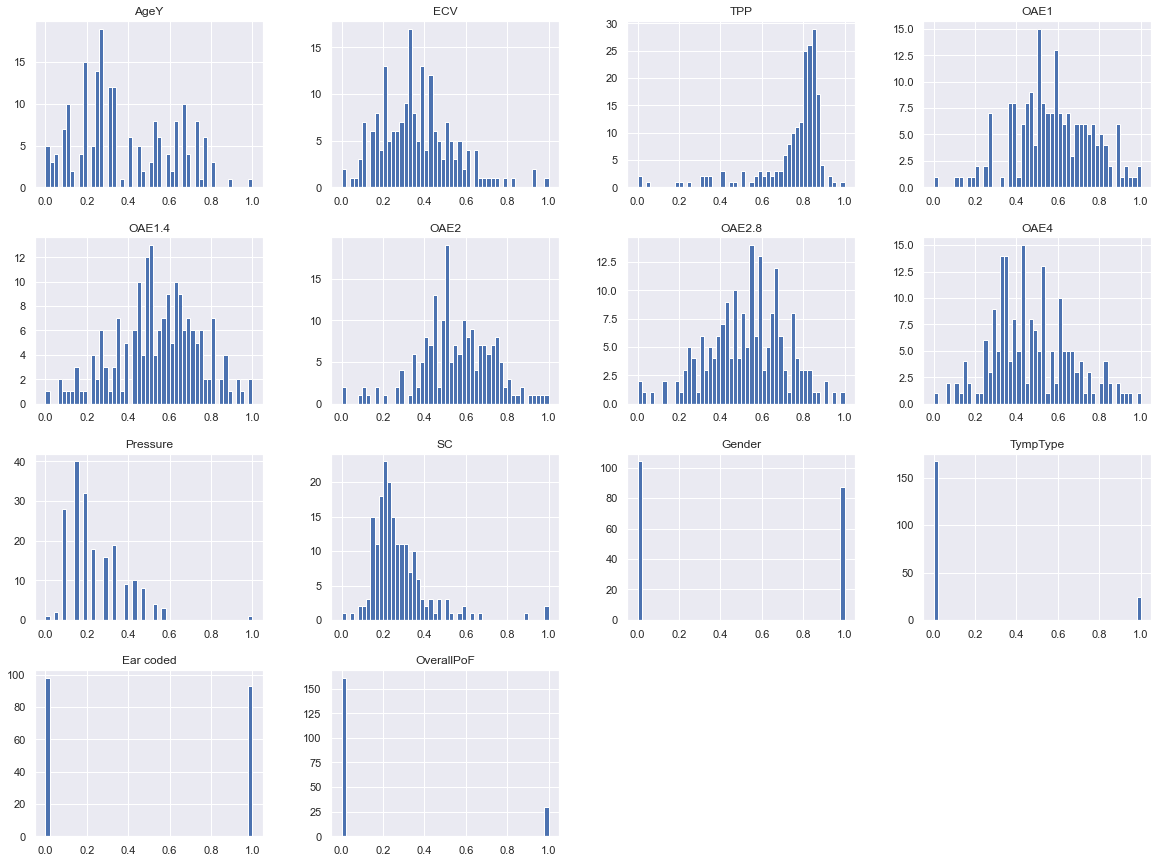

In [846]:
X_train_scaled[cont_cols].hist(bins=50, figsize=(20,15))
plt.show();

We can see that:
* TPP is left-skewed
* SC is right-skewed
* Pressure is right-skewed
* OAEs tend to be normally distributed 


Making copy of data to experiment with

In [847]:
# Experimental transformation functions
from math import exp
from math import log
from math import sqrt

# Making copy of dataframe to play around with
X_transformed = X_train_scaled.copy(deep=True)

### Right Skewed

After manual experimentation, the following transformations made SC and Pressure approximate normal distributions:
* `SC`: Root 2
* `Pressure`: Root 4

/Users/benjamintan/miniforge3/envs/tf_env/lib/python3.8/site-packages/numpy/lib/histograms.py:852: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/Users/benjamintan/miniforge3/envs/tf_env/lib/python3.8/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


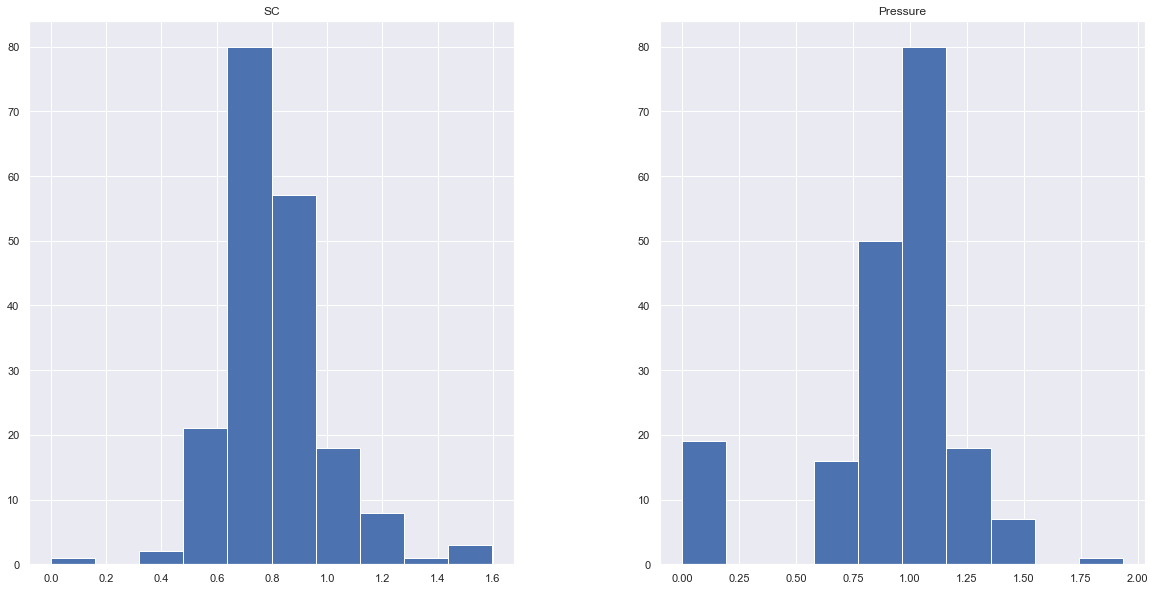

In [848]:
right_skewed = ['SC', 'Pressure']

X_transformed['SC'] = X['SC'].apply(lambda x: x**(1/2))
X_transformed['Pressure'] = X['Pressure'].apply(lambda x: x**(1/4))

X_transformed[right_skewed].hist();

### Left Skewed

After manual experimentation, the best we could get was transforming `TPP` by root 4.

The result is not perfect but it is the best we can do given our constraints (e.g. cannot do log transformations due to the 0s).

/Users/benjamintan/miniforge3/envs/tf_env/lib/python3.8/site-packages/numpy/lib/histograms.py:852: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/Users/benjamintan/miniforge3/envs/tf_env/lib/python3.8/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


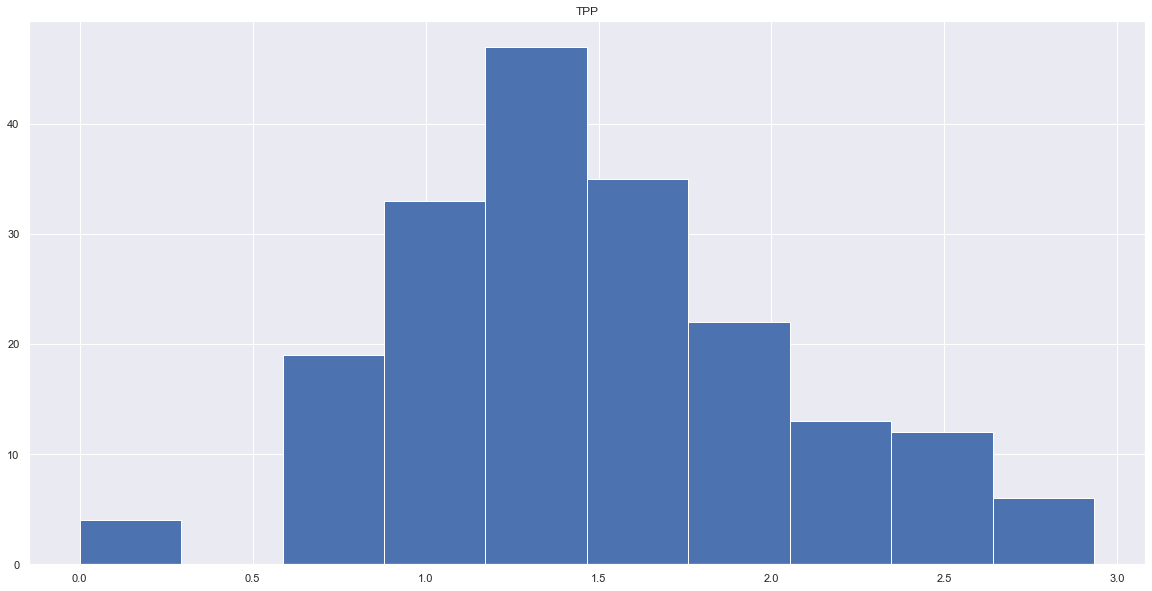

In [849]:
left_skewed = ['TPP'] # only done just in case any more left-skewed variables are added in the future

X_transformed['TPP'] = X['TPP'].apply(lambda x: x**(1/4))

X_transformed[left_skewed].hist();

### Transformation Function

Based on the above results, we will create functions to transform and un-transform our data

(Be careful to not run multiple times!)

In [850]:
def normalise(df):
    """
    Transform data based on the above results
    """
    df['SC'] = df['SC'].apply(lambda x: x**(1/2))
    df['Pressure'] = df['Pressure'].apply(lambda x: x**(1/4))
    df['TPP'] = df['TPP'].apply(lambda x: x**(1/4))
    return df

def un_normalise(df):
    """
    Reverses the normalise function
    """
    df['SC'] = df['SC'].apply(lambda x: x**2)
    df['Pressure'] = df['Pressure'].apply(lambda x: x**4)
    df['TPP'] = df['TPP'].apply(lambda x: x**4)
    return df


### Applying Transformation

Applying the above transformations if the `transformation` options is set to True.

In [851]:
if transform:
    X_train_scaled = normalise(X_train_scaled)
    X_test_scaled = normalise(X_test_scaled)

# VAE

### Sampling Layer + Reparameterization Trick

The sampling layer samples from the distributions in the latent layer. However, this makes it difficult to train the network using backpropagation. Backpropagation involves calculating the change in error/loss function with respect to changes in model weights. However, this layer involves *sampling* from distributions in the previous layer and the 'randomness' of sampling means that the aforementioned differentiation cannot be calculated. This makes the sampling layer a 'blockage' to backpropagation.\
\
To tackle this, the **reparameterization trick** is used. By making the latent vector $\mu + \sigma * \epsilon$ (i.e., multiplying $\sigma$ by $\epsilon$), where $\epsilon$ ~ Norm(0,1), a neuron is added to the sampling layer which allows backpropagation to continue through previous layers. **Read more

In [852]:
def sampling(args):
  z_mean, z_log_sigma = args
  epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.) ## reparameterisation trick
  return z_mean + K.exp(z_log_sigma) * epsilon

### Encoder

The encoder takes in an *n*-dimensional input and reduces it to (`latent_dim`) latent dimensions.

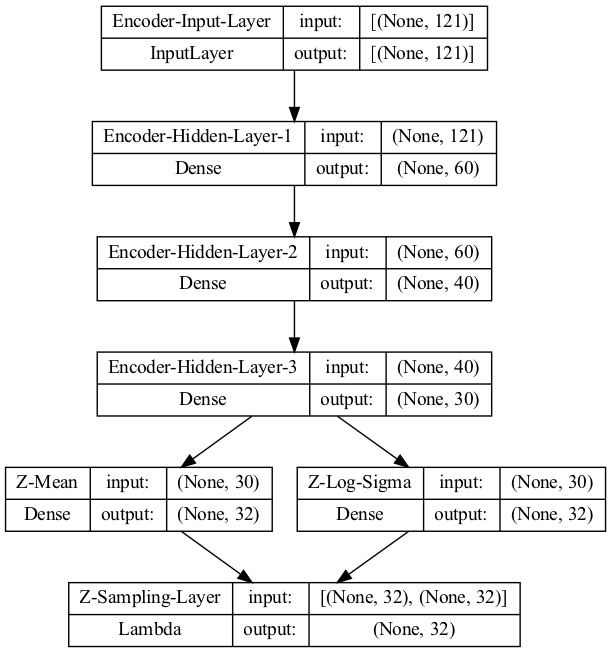

In [853]:
## Encoder
original_dim = len(X.columns)
latent_dim = 32

visible = keras.Input(shape=(original_dim,), name='Encoder-Input-Layer')

h_enc1 = Dense(units=original_dim//2, activation='selu', name='Encoder-Hidden-Layer-1')(visible) # Changed from 64, 16, 8
h_enc2 = Dense(units=original_dim//3, activation='selu', name='Encoder-Hidden-Layer-2')(h_enc1)
h_enc3 = Dense(units=original_dim//4, activation='selu', name='Encoder-Hidden-Layer-3')(h_enc2)

z_mean = Dense(units=latent_dim, name='Z-Mean')(h_enc3)
z_log_sigma = Dense(units=latent_dim, name='Z-Log-Sigma')(h_enc3)
z = Lambda(sampling, name='Z-Sampling-Layer')([z_mean, z_log_sigma])

encoder = Model(visible, [z_mean, z_log_sigma, z], name='Encoder-Model')

plot_model(encoder, show_shapes=True, dpi=100)

### Decoder

The decoder re-constructs (a variant of, in this case) the initial input, by sampling from the mean and standard deviation distributions in the latent layer.

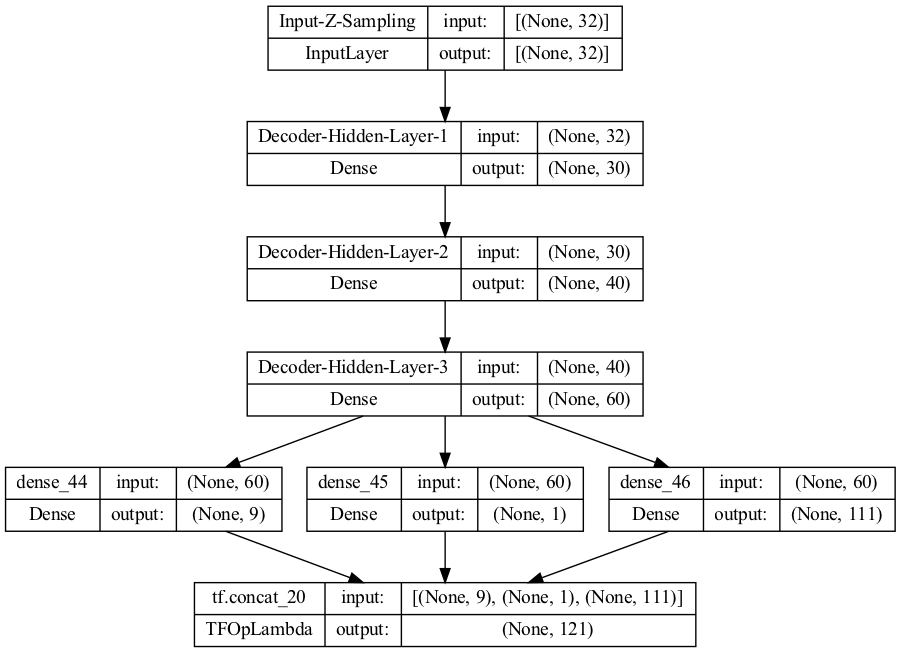

In [854]:
## Decoder
latent_inputs = Input(shape=(latent_dim,), name='Input-Z-Sampling')

h_dec = Dense(units=original_dim//4, activation='selu', name='Decoder-Hidden-Layer-1')(latent_inputs)
h_dec2 = Dense(units=original_dim//3, activation='selu', name='Decoder-Hidden-Layer-2')(h_dec)
h_dec3 = Dense(units=original_dim//2, activation='selu', name='Decoder-Hidden-Layer-3')(h_dec2)

## Multi output activation
# Linear for control variables outside (0,1) range
# Sigmoid for binary variables and frequencies, as they are all (0,1)
if multi_activation:
    # No activation (all non-positive-only and non-binary control variables)
    output_1 = Dense(units = len(cont_cols) - len(pos_cols) - len(bin_cols), activation=None)(h_dec3)

    # SoftPlus (positive values only, any range) 
    output_2 = Dense(units = len(pos_cols), activation='exponential')(h_dec3) # softplus

    # Sigmoid (binonmial + frequencies)
    output_3 = Dense(units = len(bin_cols) + len(freq_cols), activation='sigmoid')(h_dec3)

    # Combining into one layer
    outputs = concat([output_1, output_2, output_3], axis=1)
##
else:
# Single output activation
    outputs = Dense(original_dim, activation='sigmoid', name='Decoder-Output-Layer')(h_dec3)

decoder = Model(latent_inputs, outputs, name='Decoder-Model')

plot_model(decoder, show_shapes=True, dpi=100)

In [855]:
## Autoencoder

# Reference -- From above:
### visible = keras.Input(shape=(original_dim,), name='Encoder-Input-Layer')

outpt = decoder(
    encoder(visible)[2] # Encode the input and take the 3rd element of the output (z-score)
    )

# Set mode parameters (number of inputs/outputs)
vae = Model(inputs=visible, outputs=outpt, name='VAE-Model')

### Loss Function

We use mean-squared error loss (i.e., mean squared difference between encoder input and decoder output).

**KL-Divergence**\
As variational autoencoders sample from distributions with, in this case, the goal of generating *new* samples, the loss function needs to be altered for that goal. In other words, we don't want the output to be exactly the same as the input - we want features of the output to come from the same distributions as features from the input, such that the output is a realistic synthetic observation that can be used for analysis.\
Thus, we add a *Kullback-Leibler (KL) Divergence* term, which calculates the difference between **probability distributions**. 

In [856]:
## Loss Function
r_loss = original_dim * keras.losses.mse(visible, outpt)
kl_loss = -0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis = 1)
vae_loss = K.mean(r_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

### Model Training

Epoch 1/25
12/12 [==============================] - 2s 71ms/step - loss: 38.3376 - val_loss: 27.0447
Epoch 2/25
12/12 [==============================] - 0s 36ms/step - loss: 21.9975 - val_loss: 18.2747
Epoch 3/25
12/12 [==============================] - 1s 73ms/step - loss: 16.1986 - val_loss: 15.3814
Epoch 4/25
12/12 [==============================] - 1s 64ms/step - loss: 13.0995 - val_loss: 13.6788
Epoch 5/25
12/12 [==============================] - 1s 45ms/step - loss: 11.2079 - val_loss: 12.9625
Epoch 6/25
12/12 [==============================] - 0s 37ms/step - loss: 9.9076 - val_loss: 11.5627
Epoch 7/25
12/12 [==============================] - 0s 36ms/step - loss: 8.7420 - val_loss: 10.9189
Epoch 8/25
12/12 [==============================] - 0s 41ms/step - loss: 8.2974 - val_loss: 11.8109
Epoch 9/25
12/12 [==============================] - 0s 37ms/step - loss: 8.1271 - val_loss: 10.4546
Epoch 10/25
12/12 [==============================] - 0s 37ms/step - loss: 7.6889 - val_loss: 10

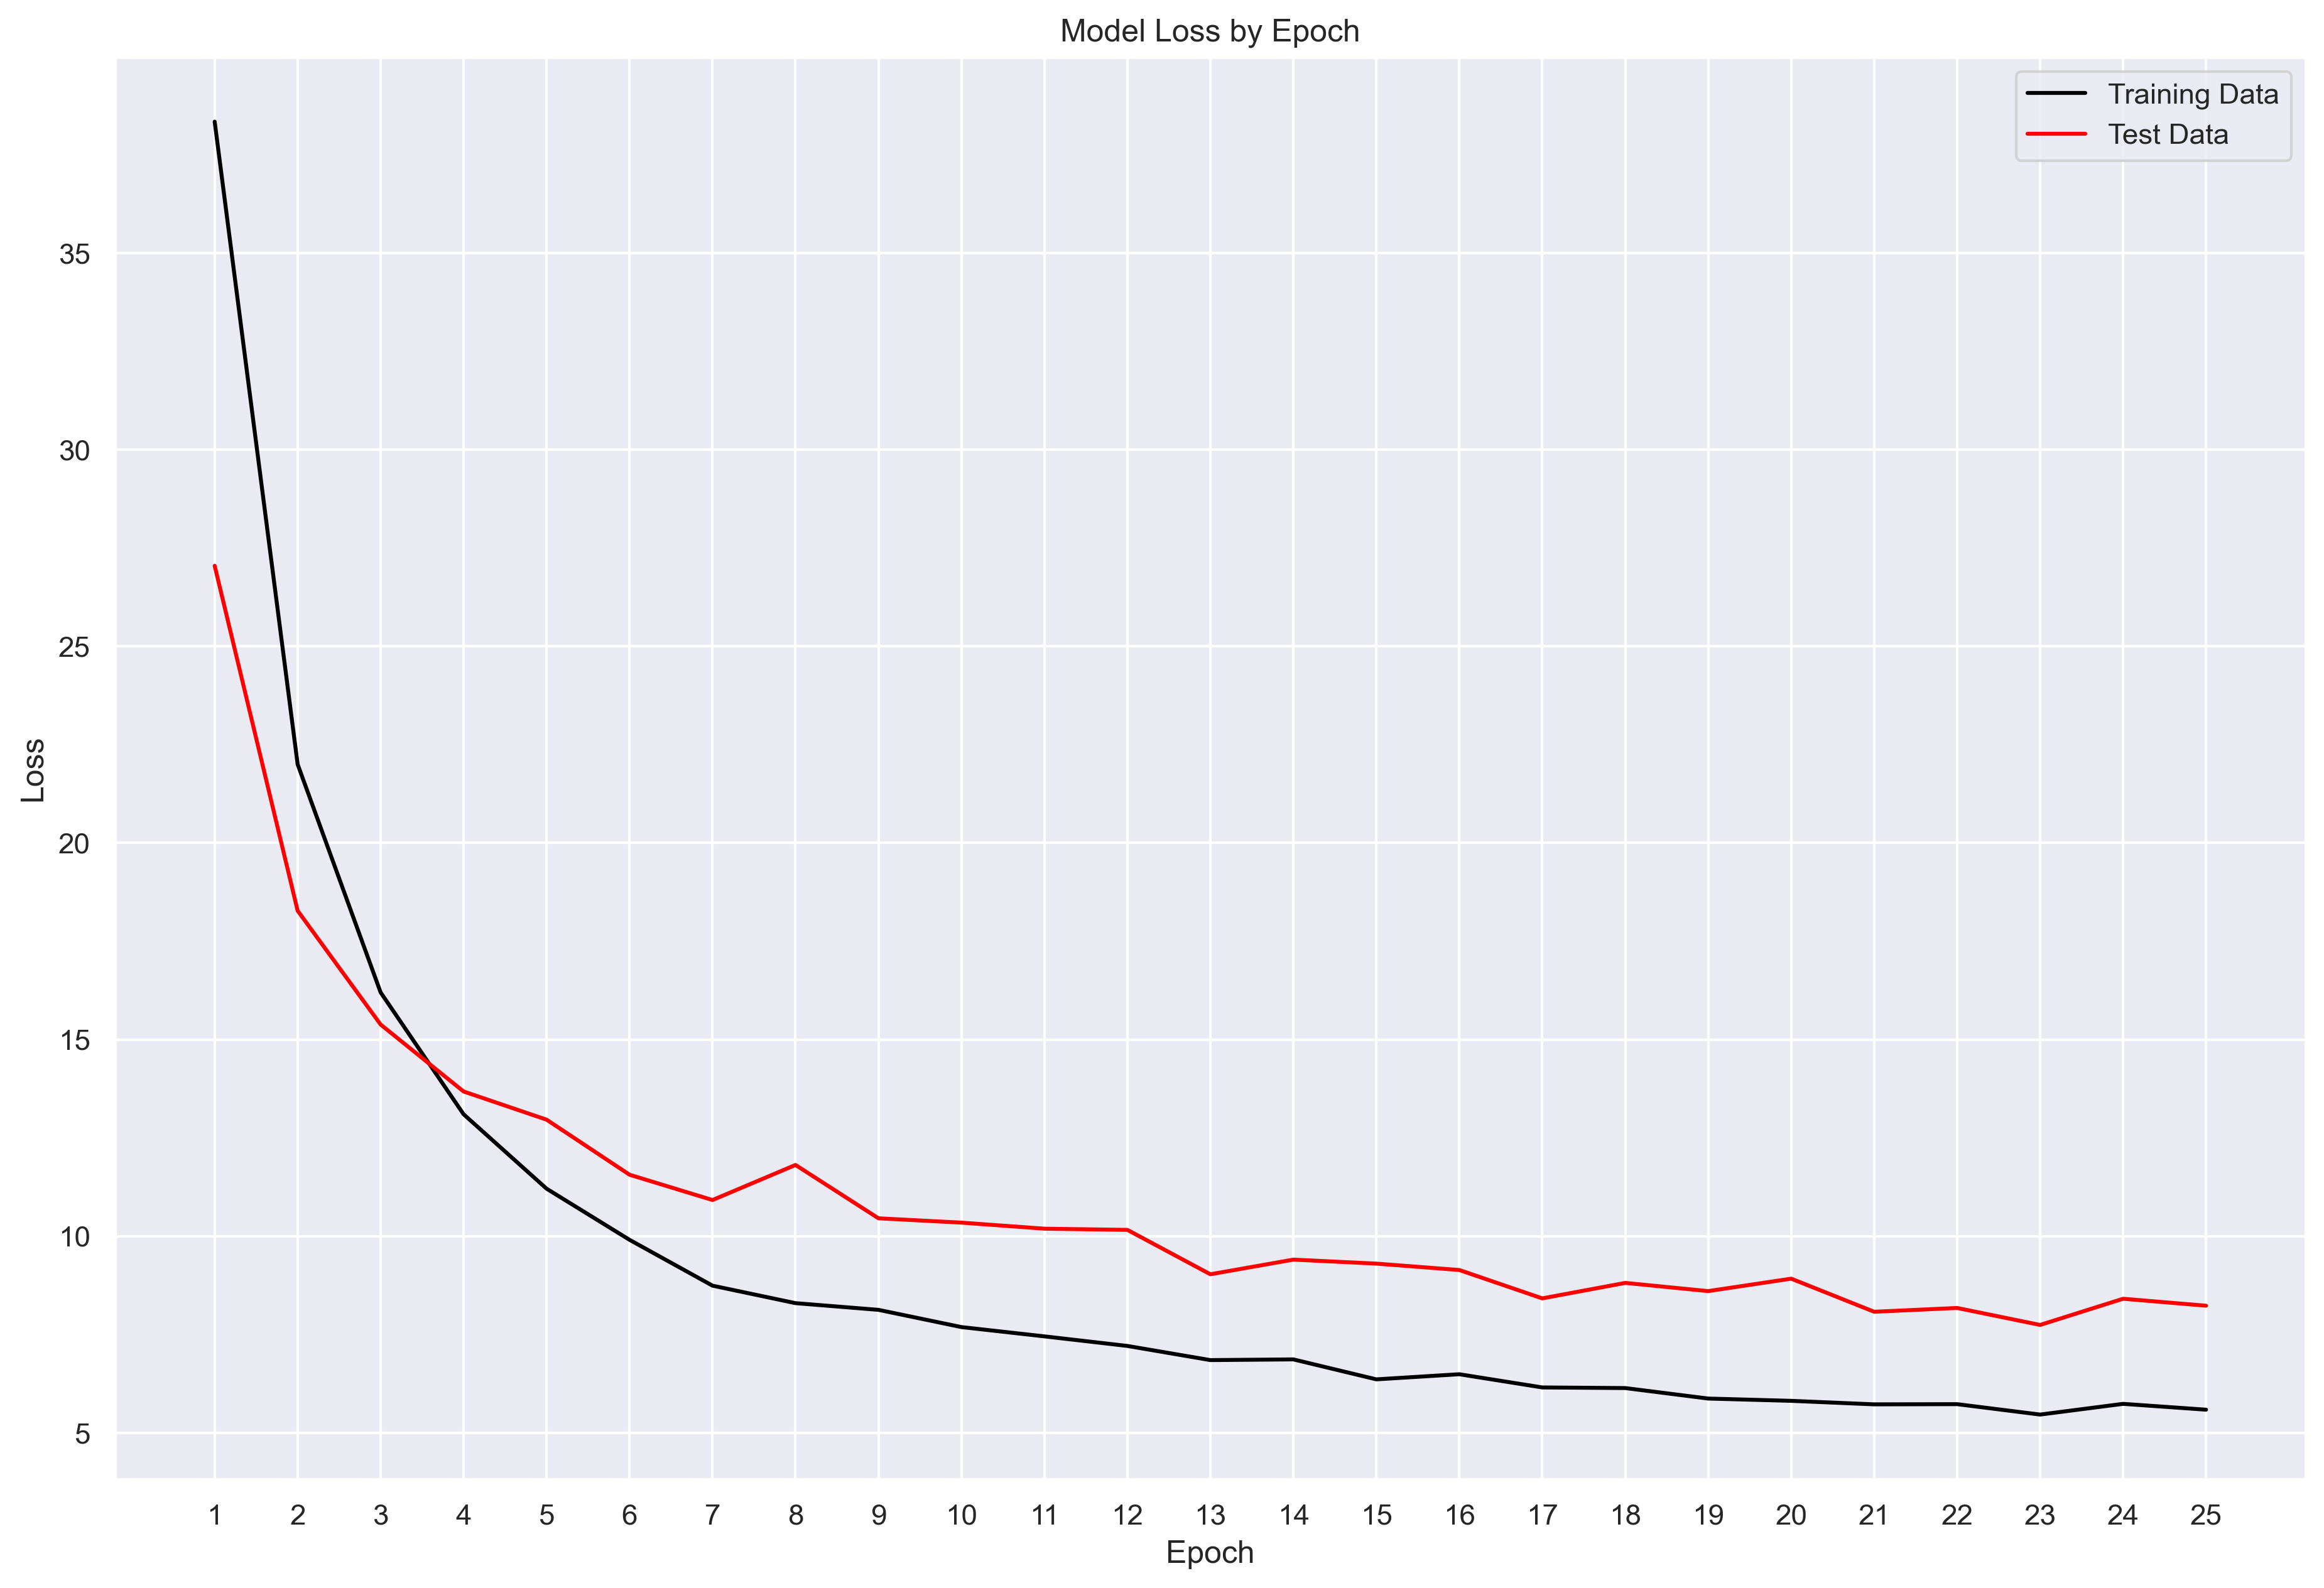

In [857]:
# Model fit
history = vae.fit(X_train_scaled, X_train_scaled, epochs=25, batch_size=16, validation_data=(X_test_scaled, X_test_scaled))

sns.set(rc={'figure.figsize':(20,10)})

# Plot loss over time
fig, ax = plt.subplots(figsize=(15,10), dpi=300)
plt.title(label='Model Loss by Epoch', loc='center')

ax.plot(history.history['loss'], label='Training Data', color='black')
ax.plot(history.history['val_loss'], label='Test Data', color='red')
ax.set(xlabel='Epoch', ylabel='Loss')
plt.xticks(ticks=np.arange(len(history.history['loss']), step=1), labels=np.arange(1, len(history.history['loss'])+1, step=1));
plt.legend()
plt.show();

### Visualising (2) Latent Dimensions

In [858]:
if latent_dim == 2:
    ## Visualise Latent Space
    plt.style.use('ggplot')

    X_test_encoded = encoder.predict(X_test_scaled)

    colours = {
        1:"r",
        0:"g"
    }

    fig, ax = plt.subplots()
    # encoder returns 3 arrays, z-mean, z-log-sigma, z 
    scatter = ax.scatter(
                        X_test_encoded[2][:,0],
                        X_test_encoded[2][:,1],
                        c=y_test['OverallPoF'].map(colours)
                        )
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_title("WBA Representation in the 2D Latent Space")
    ax.legend(*scatter.legend_elements(), loc="lower left", title="Overall Pass or Fail")
    plt.show()
else:
    print("Cannot visualise latent space for >2 dimensions.\nNumber of dimensions: {}.".format(latent_dim))

Cannot visualise latent space for >2 dimensions.
Number of dimensions: 32.


Printing sample

In [859]:
if latent_dim == 2:
    ## Generate from latent space
    z_sample = [[-1.8,-0.3]]
    wba_decoded = decoder.predict(z_sample)
    wba_decoded[0]

## Generating Samples from VAE

With the trained VAE, we generate samples. To do this, we generate random numbers (random value between -z_range and +z_range) to map to each latent dimension (distribution). These numbers are used to sample from the latent distributions.

`z_sample` will be a list of lists, with each embedded list having the same number of elements as the number of latent dimensions.

In [860]:
from random import seed
from random import random

seed(1)

n_samples = 10000
z_sample = []
z_range = 3

for _ in range(n_samples):
  sample = []
  for _ in range(latent_dim):
    # Generate number between (-z_range and +z_range)
    sample.append(-z_range + (random() * (z_range*2)))
  z_sample.append(sample)

Using the values from `z_sample` to select values from the latent distributions (i.e., generating observations).

In [861]:
# Generate synthetic observations
wba_decoded = decoder.predict(z_sample)

# Convert to dataframe
wba_decoded = pd.DataFrame(wba_decoded, columns = X.columns)

313/313 [==============================] - 2s 5ms/step


### Pre-Preprocessing Reversal

Reversing the normalisation of distirbutions and MinMaxScaler

In [862]:
# Reverse the transformation pre-processing (un-normalisation of distirbutions)
if transform:
    wba_decoded = un_normalise(wba_decoded)

# Reversing MinMaxScaler
unscaled = scaler.inverse_transform(wba_decoded)

# Converting to dataframe
gen_df = pd.DataFrame(unscaled, columns = X.columns)

Rounding binary variables to closest whole number.

Binary variables' values can be interpreted as probabilities of having the value of 1 as the neural network maps these values to log likelihoods followed by sigmoid functions.

In [863]:
# if not pass_only:
#     gen_df['OverallPoF'] = round(gen_df['OverallPoF'])

# for bin_col in bin_cols:
#     if bin_col == "OverallPoF":
#         pass
#     else:
#         gen_df[bin_col] = round(gen_df[bin_col])

for bin_col in bin_cols:
    gen_df[bin_col] = round(gen_df[bin_col])

# Generated Data Assessment

## Making Long Format

In [864]:
# Frequencies only

if pass_only:
    gen_freqs_long = gen_df[freq_cols].copy(deep=True)
    gen_freqs_long = gen_freqs_long.melt()

    freqs_long = full_data[freq_cols].melt()

else:
    gen_freqs_long = gen_df[freq_cols + ['OverallPoF']].copy(deep=True)
    gen_freqs_long = gen_freqs_long.melt(['OverallPoF'])
    freqs_long = full_data[freq_cols + ['OverallPoF']].melt('OverallPoF')


## Frequency Distribution Comparison

### Generated Data

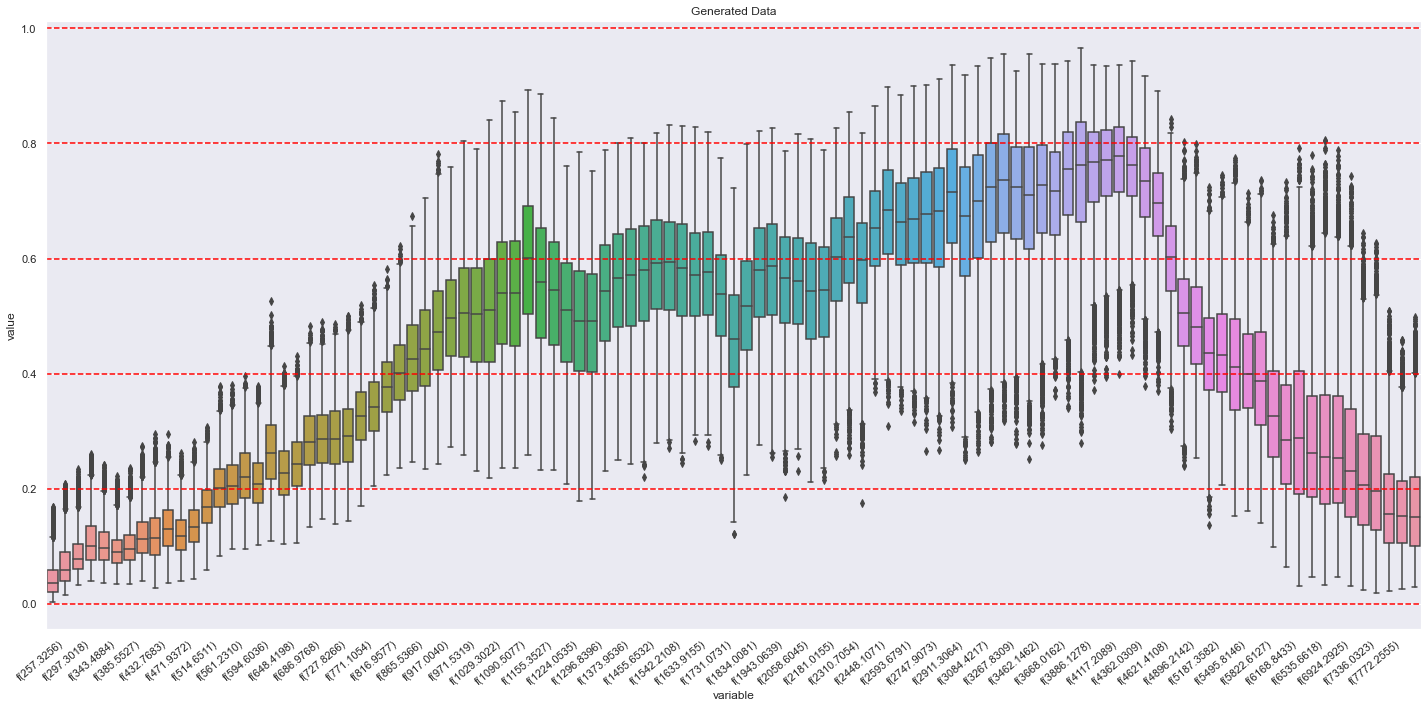

In [865]:
sns.set(rc={'figure.figsize':(20,10)})
ax = sns.boxplot(x="variable", y="value", data=gen_freqs_long)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set(title='Generated Data')
ax.axhline(1.0, ls='--', color='red')
ax.axhline(0.8, ls='--', color='red')
ax.axhline(0.6, ls='--', color='red')
ax.axhline(0.4, ls='--', color='red')
ax.axhline(0.2, ls='--', color='red')
ax.axhline(0.0, ls='--', color='red')

sns.set(rc={'figure.figsize':(20,10)})
plt.setp(ax.get_xticklabels()[::2], visible=False)

plt.tight_layout()
plt.show();

### Original Data

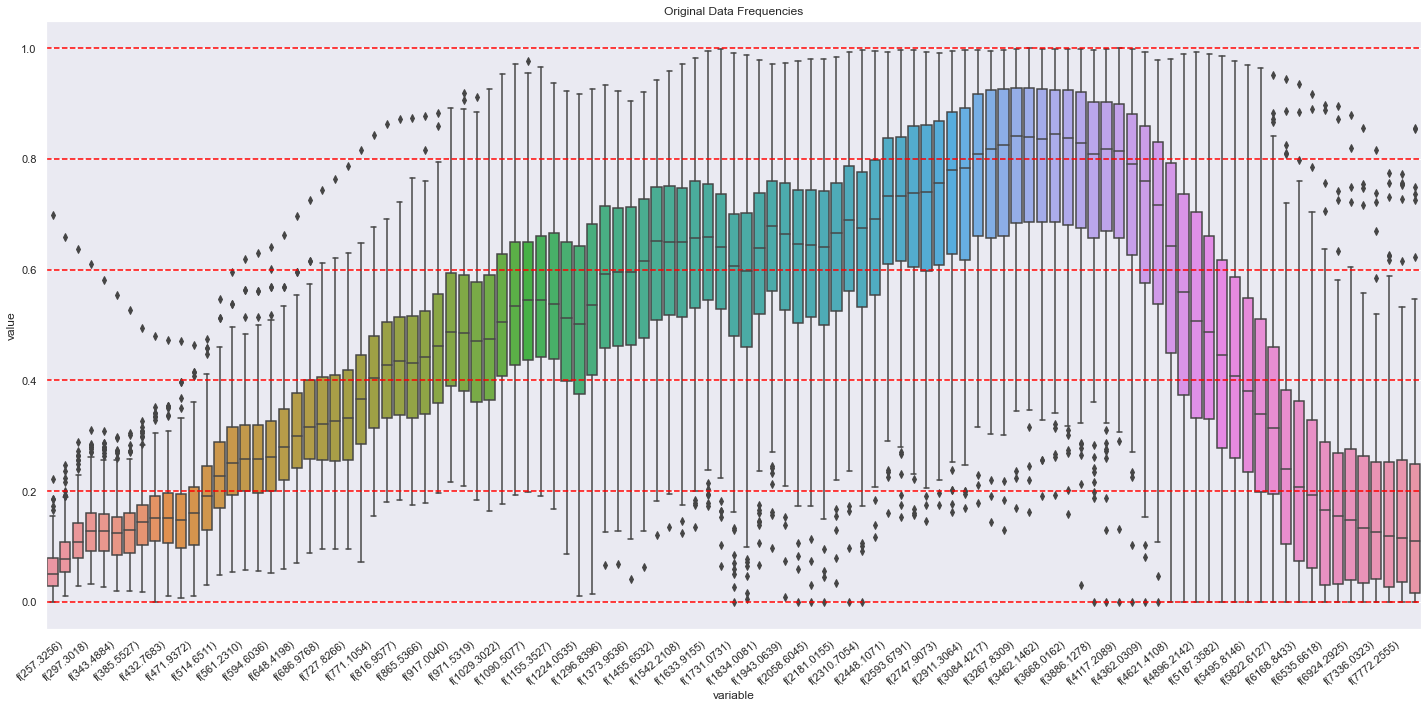

In [866]:
sns.set(rc={'figure.figsize':(20,10)})
ax = sns.boxplot(x="variable", y="value", data=freqs_long)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set(title='Original Data Frequencies')
ax.axhline(1.0, ls='--', color='red')
ax.axhline(0.8, ls='--', color='red')
ax.axhline(0.6, ls='--', color='red')
ax.axhline(0.4, ls='--', color='red')
ax.axhline(0.2, ls='--', color='red')
ax.axhline(0.0, ls='--', color='red')

plt.setp(ax.get_xticklabels()[::2], visible=False)

plt.tight_layout()
plt.show();

## Pass/Fail Distribution Comparison

### Generated Data

<ipython-input-867-ba875b0766af>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")


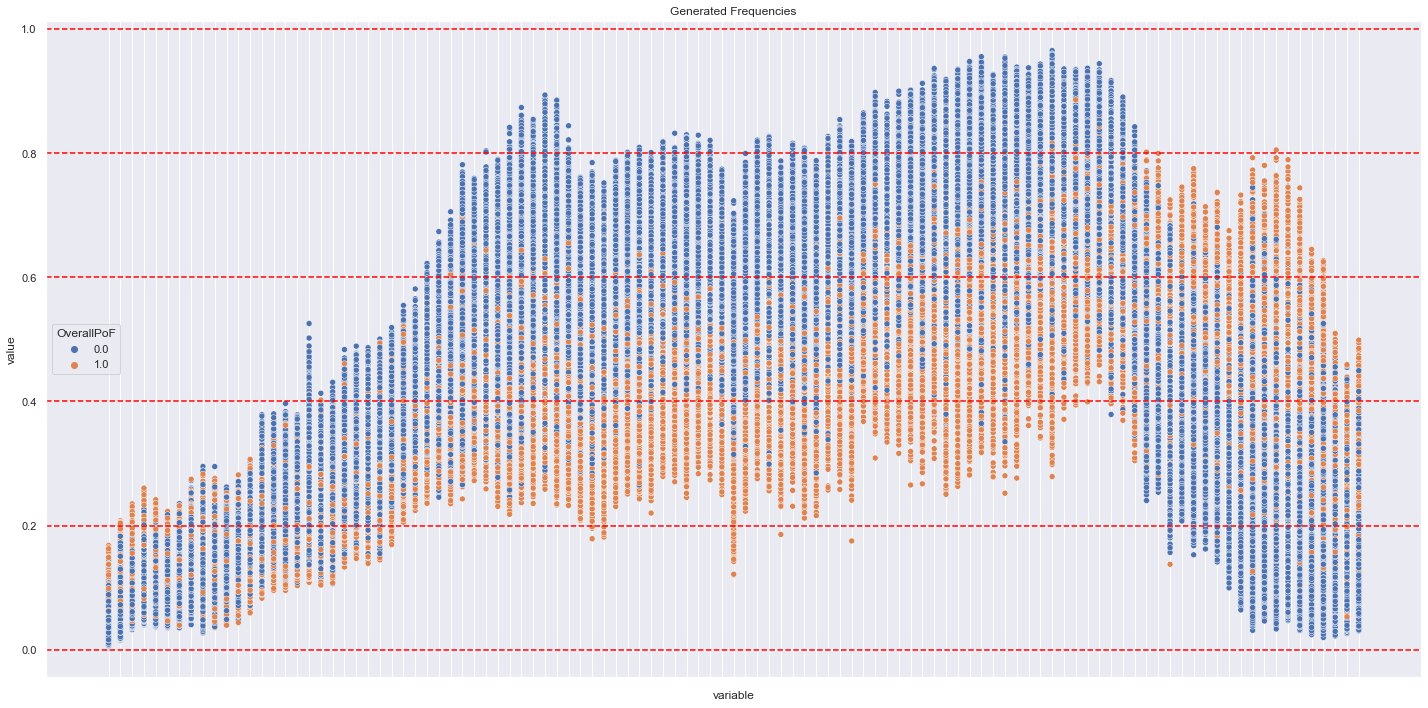

In [867]:
if not pass_only:
    ax = sns.scatterplot(data = gen_freqs_long, x='variable', y='value', hue='OverallPoF')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    ax.set(title="Generated Frequencies")
else:
    ax = sns.scatterplot(data = gen_freqs_long, x='variable', y='value')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    ax.set(title="Generated Frequencies")

# Horizontal lines
ax.axhline(1, ls='--', color='red')
ax.axhline(0.8, ls='--', color='red')
ax.axhline(0.6, ls='--', color='red')
ax.axhline(0.4, ls='--', color='red')
ax.axhline(0.2, ls='--', color='red')
ax.axhline(0.0, ls='--', color='red')

plt.setp(ax.get_xticklabels()[::2], visible=False)

plt.tight_layout()
plt.show();

### Original Data

<ipython-input-868-8758f399dd16>:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")


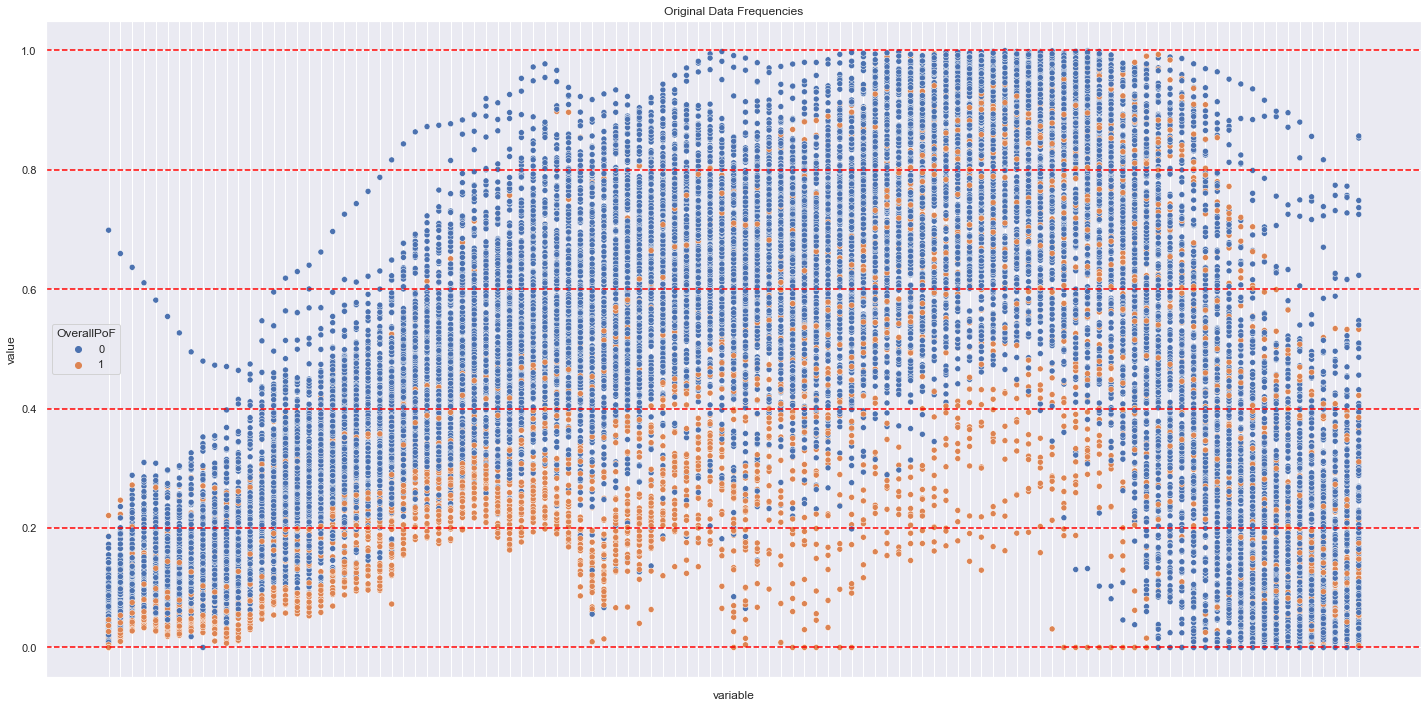

In [868]:
ax = sns.scatterplot(data = freqs_long, x='variable', y='value', hue='OverallPoF')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set(title="Original Data Frequencies")

# Horizontal lines
ax.axhline(1, ls='--', color='red')
ax.axhline(0.8, ls='--', color='red')
ax.axhline(0.6, ls='--', color='red')
ax.axhline(0.4, ls='--', color='red')
ax.axhline(0.2, ls='--', color='red')
ax.axhline(0.0, ls='--', color='red')

plt.setp(ax.get_xticklabels()[::2], visible=False)

plt.tight_layout()
plt.show();

Class counts comparison

In [869]:
if not pass_only:
    print(gen_df['OverallPoF'].value_counts())

0.0    7783
1.0    2217
Name: OverallPoF, dtype: int64


In [870]:
print(full_data['OverallPoF'].value_counts())

0    201
1     38
Name: OverallPoF, dtype: int64


## Comparing Control Variables

### Numerical Summaries

In [871]:
gen_df[cont_cols].describe()

,AgeY,ECV,TPP,OAE1,OAE1.4,OAE2,OAE2.8,OAE4,Pressure,SC,Gender,TympType,Ear coded,OverallPoF
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8.654736,1.081570,-106.578972,12.491356,17.100452,11.303791,7.673243,5.676687,-2.001443,1.126899,0.472800,0.217200,0.437200,0.221700
std,0.753286,0.274412,87.410156,11.061949,9.218348,8.510589,5.303903,6.771986,2.134363,1.099441,0.499279,0.412344,0.496074,0.415422
min,5.576030,0.109122,-458.864258,-44.733418,-30.073309,-36.435997,-14.465097,-23.164604,-10.869534,-1.722393,0.000000,0.000000,0.000000,0.000000
25%,8.163616,0.897883,-164.564911,5.547622,11.091020,6.042490,4.285501,1.297182,-3.389916,0.349923,0.000000,0.000000,0.000000,0.000000
50%,8.665009,1.067192,-105.396923,12.924265,17.095016,11.547207,7.804462,5.826072,-2.028606,1.081165,0.000000,0.000000,0.000000,0.000000
75%,9.162387,1.256733,-48.057009,19.739207,22.941429,17.035976,11.244915,10.243749,-0.608195,1.833622,1.000000,0.000000,1.000000,0.000000
max,11.553357,2.392101,259.325073,57.485703,69.266457,49.457321,25.308100,31.693811,8.401697,5.822865,1.000000,1.000000,1.000000,1.000000


In [872]:
X[cont_cols].describe()

,AgeY,ECV,TPP,OAE1,OAE1.4,OAE2,OAE2.8,OAE4,Pressure,SC,Gender,TympType,Ear coded,OverallPoF
count,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000
mean,8.882635,0.995969,-37.221027,10.402094,12.985864,12.324084,10.384764,9.163874,-1.931937,0.697246,0.455497,0.125654,0.486911,0.157068
std,0.688410,0.226848,59.243475,6.478693,6.501770,5.790232,4.758320,5.344629,2.883816,0.350686,0.499324,0.332331,0.501142,0.364821
min,7.750000,0.530000,-296.000000,-9.600000,-4.800000,-5.700000,-3.000000,-3.900000,-7.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.333333,0.825000,-44.500000,6.350000,9.300000,9.000000,7.400000,5.400000,-4.000000,0.485000,0.000000,0.000000,0.000000,0.000000
50%,8.666667,0.970000,-16.000000,10.300000,13.300000,12.000000,11.000000,8.300000,-3.000000,0.610000,0.000000,0.000000,0.000000,0.000000
75%,9.458333,1.115000,-2.000000,15.000000,17.350000,16.400000,13.950000,13.000000,0.000000,0.800000,1.000000,0.000000,1.000000,0.000000
max,10.750000,1.810000,51.000000,25.100000,28.000000,27.000000,22.400000,23.900000,14.000000,2.550000,1.000000,1.000000,1.000000,1.000000


### Histograms

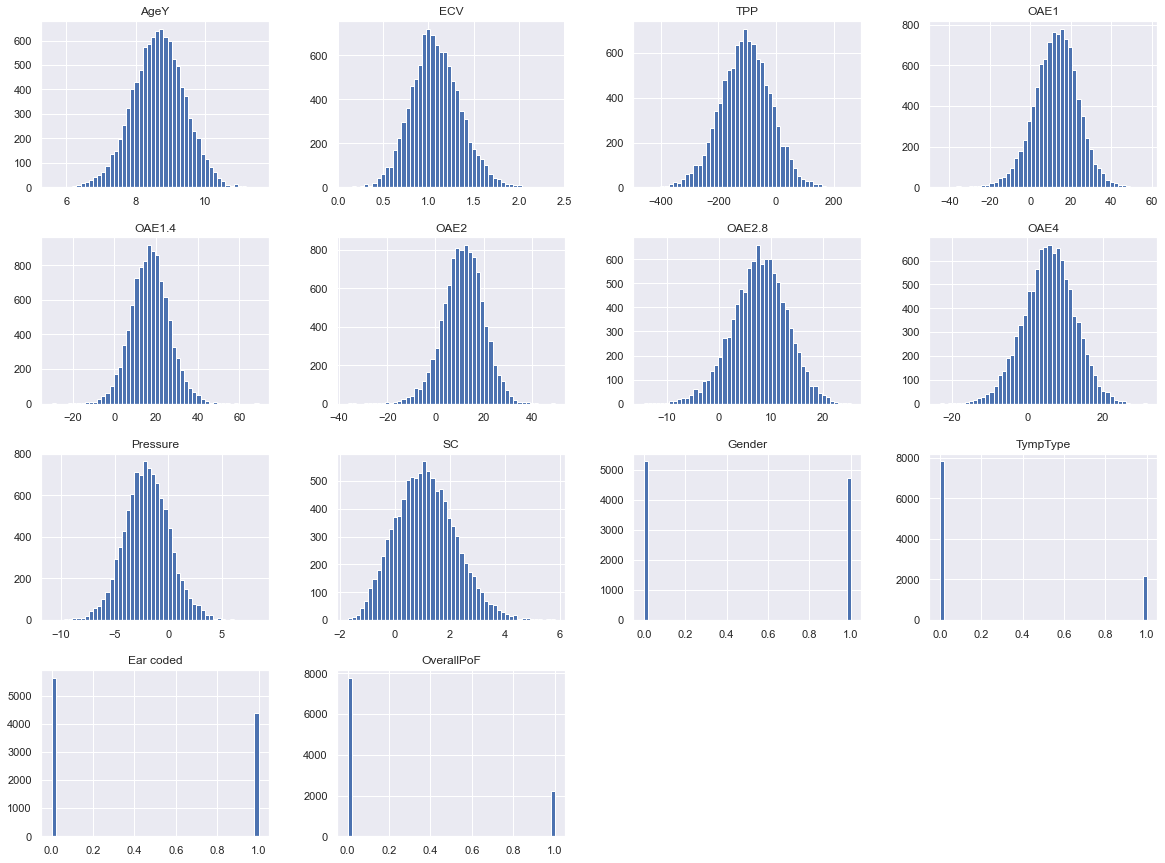

In [873]:
gen_df[cont_cols].hist(bins=50, figsize=(20,15))
plt.show();

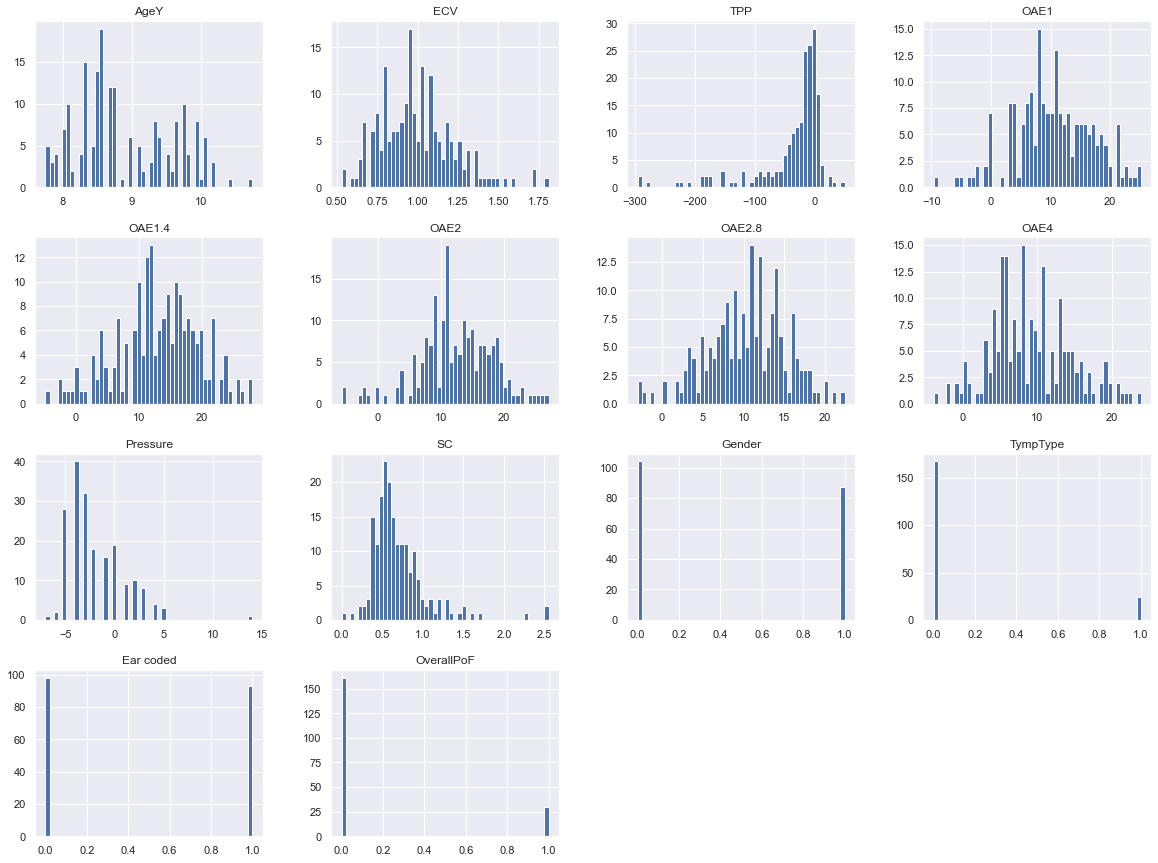

In [874]:
X[cont_cols].hist(bins=50, figsize=(20,15))
plt.show();

In [875]:
# gen_df_long.to_csv("gen_df_long.csv")